In [15]:
%env VAULT_ADDR=https://vault-cluster-public-vault-d4e71bb2.39ea30b7.z1.hashicorp.cloud:8200
%env VAULT_TOKEN=hvs.CAESII0ggf_xy67UFD9Sccg8vpD7s3EwAHvEvRy3pvkag7VnGigKImh2cy44TE1GNHd4OXltZUNGMWI2ZE5na28yRjkud2FNY00QioAB
%env VAULT_NAMESPACE=admin
%env BOUNDARY_ADDR=https://8cd58e1c-2e7a-4b63-b475-21f5fb2f38c4.boundary.hashicorp.cloud

env: VAULT_ADDR=https://vault-cluster-public-vault-d4e71bb2.39ea30b7.z1.hashicorp.cloud:8200
env: VAULT_TOKEN=hvs.CAESII0ggf_xy67UFD9Sccg8vpD7s3EwAHvEvRy3pvkag7VnGigKImh2cy44TE1GNHd4OXltZUNGMWI2ZE5na28yRjkud2FNY00QioAB
env: VAULT_NAMESPACE=admin
env: BOUNDARY_ADDR=https://8cd58e1c-2e7a-4b63-b475-21f5fb2f38c4.boundary.hashicorp.cloud


In [2]:
%%bash
vault secrets list

Path                  Type            Accessor                 Description
----                  ----            --------                 -----------
cubbyhole/            ns_cubbyhole    ns_cubbyhole_04e75ab9    per-token private secret storage
database/             database        database_5771d4c4        This is an example Database Example
identity/             ns_identity     ns_identity_d5ae937d     identity store
secrets/              kv              kv_e7964edb              Key-Value Secrets Engine
ssh-client-signer/    ssh             ssh_bfdda0a2             This is an example SSH Engine
sys/                  ns_system       ns_system_1c78f1bb       system endpoints used for control, policy and debugging


## Step 1: Crear autenticación en Vault

In [3]:
%%bash
vault auth enable userpass

vault policy write oidc-auth - << EOF
path "identity/oidc/provider/my-provider/authorize" {
capabilities = [ "read" ]
}
EOF

vault write auth/userpass/users/end-user \
    password="password" \
    token_policies="oidc-auth" \
    token_ttl="1h"




Success! Enabled userpass auth method at: userpass/
Success! Uploaded policy: oidc-auth
Success! Data written to: auth/userpass/users/end-user


In [4]:
%%bash
vault write identity/entity \
    name="end-user" \
    metadata="email=vault@hashicorp.com" \
    metadata="phone_number=123-456-7890" \
    disabled=false

ENTITY_ID=$(vault read -field=id identity/entity/name/end-user)

vault write identity/group \
    name="engineering" \
    member_entity_ids="$ENTITY_ID"

GROUP_ID=$(vault read -field=id identity/group/name/engineering)

USERPASS_ACCESSOR=$(vault auth list -detailed -format json | jq -r '.["userpass/"].accessor')

vault write identity/entity-alias \
    name="end-user" \
    canonical_id="$ENTITY_ID" \
    mount_accessor="$USERPASS_ACCESSOR"


Key        Value
---        -----
aliases    <nil>
id         08f453c3-2cf4-989c-2a69-61aea34696f0
name       end-user
Key     Value
---     -----
id      ff1d86ed-fec1-e6c3-2be1-d4391f88e439
name    engineering
Key             Value
---             -----
canonical_id    08f453c3-2cf4-989c-2a69-61aea34696f0
id              9b48ec6f-1368-81ac-c059-ac7a32e2aa2e


In [6]:
%%bash
vault write identity/oidc/assignment/my-assignment \
    entity_ids="${ENTITY_ID}" \
    group_ids="${GROUP_ID}"

vault write identity/oidc/key/my-key \
    allowed_client_ids="*" \
    verification_ttl="2h" \
    rotation_period="1h" \
    algorithm="RS256"

vault write identity/oidc/client/boundary \
    redirect_uris="http://127.0.0.1:9200/v1/auth-methods/oidc:authenticate:callback" \
    assignments="my-assignment" \
    key="my-key" \
    id_token_ttl="30m" \
    access_token_ttl="1h"





Success! Data written to: identity/oidc/assignment/my-assignment
Success! Data written to: identity/oidc/key/my-key
Success! Data written to: identity/oidc/client/boundary


bash: line 28: warning: command substitution: 1 unterminated here-document
bash: line 29: warning: here-document at line 28 delimited by end-of-file (wanted `echo')
base64: invalid argument {
Usage:	base64 [-hDd] [-b num] [-i in_file] [-o out_file]
  -h, --help     display this message
  -Dd, --decode   decodes input
  -b, --break    break encoded string into num character lines
  -i, --input    input file (default: "-" for stdin)
  -o, --output   output file (default: "-" for stdout)


Success! Data written to: identity/oidc/scope/user


In [9]:
%%bash 
export CLIENT_ID=$(vault read -field=client_id identity/oidc/client/boundary)
export USER_SCOPE_TEMPLATE='{
    "username": {{identity.entity.name}},
    "contact": {
        "email": {{identity.entity.metadata.email}},
        "phone_number": {{identity.entity.metadata.phone_number}}
    }
}'
vault write identity/oidc/scope/user \
    description="The user scope provides claims using Vault identity entity metadata" \
    template="$(echo -n ${USER_SCOPE_TEMPLATE} | base64)"



Success! Data written to: identity/oidc/scope/user


In [10]:
%%bash
GROUPS_SCOPE_TEMPLATE='{
    "username": {{identity.entity.name}},
    "contact": {
        "email": {{identity.entity.metadata.email}},
        "phone_number": {{identity.entity.metadata.phone_number}}
    }
}'

vault write identity/oidc/scope/groups \
    description="The groups scope provides the groups claim using Vault group membership" \
    template="$(echo -n ${GROUPS_SCOPE_TEMPLATE} | base64)"

export CLIENT_ID=$(vault read -field=client_id identity/oidc/client/boundary)

vault write identity/oidc/provider/my-provider \
    allowed_client_ids="${CLIENT_ID}" \
    scopes_supported="groups,user"


Success! Data written to: identity/oidc/scope/groups


WARNING! The following warnings were returned from Vault:

  * Found scope templates with conflicting top-level keys: conflict "username"
  in scopes "user", "groups". This may result in an error if the scopes are
  requested in an OIDC Authentication Request.

  * Found scope templates with conflicting top-level keys: conflict "contact"
  in scopes "user", "groups". This may result in an error if the scopes are
  requested in an OIDC Authentication Request.



In [12]:
%%bash
curl -s --header "X-Vault-Token: $VAULT_TOKEN" --request GET \
    --header "X-Vault-Namespace: $VAULT_NAMESPACE" \
    $VAULT_ADDR/v1/identity/oidc/provider/my-provider/.well-known/keys | jq


{
  "keys": [
    {
      "use": "sig",
      "kty": "RSA",
      "kid": "2d7df1ca-45bd-24ab-c966-5eeb4683f18c",
      "alg": "RS256",
      "n": "r3Lb_bZ7d-JNhyjzxt169K6YA_74JyI1tcLwk2lKIl2Cenn2Lqwk5XU7fOph7V3h1UFPQJYKkNfbQex-DMg8AYyTFue7080PIPvnsEnNQoQUC39VkKA662oL8Vf2nf2eDQ-_5ygimkvvAhDFuYEeN03xMRzHRz3BgpeRGt1aS0EXanYL3oiDuXa820igsuv2OhKOpl6a-kjDdD7eYcAlWxjXBBxWr0saH3EDMBiHGEwkzJKo6a4CuYRjyEvHycYK8vkZZyrHPECJEeJHjgJglQm6KivUYDlIY5QFKZPVEVMTgC1xmAvWZP9WOt0-vvyRy40xFz9xpyLPaByAT2XrFQ",
      "e": "AQAB"
    },
    {
      "use": "sig",
      "kty": "RSA",
      "kid": "6eba6f9f-9f33-ed42-1adc-91e7305c4cc5",
      "alg": "RS256",
      "n": "oWLiqzQrRh2R6yrhgN_wH4jb2TY1D-_yhcye1M0RnmeOVUtHEbbvQ59kDzdZ_XsRADuLe1XgEVULv9q8J5PbieOMKnQsALTqVABLx9MyJKRhDNIZg7Db9Ocvv_D3Ib5kN6isFCkv8QMljIAl6YMzvTrgc1bPPZjqLcxZ3-QS_A_7CxIdIBYGe4FR6iDM1FHVB_i162J5Bkaz9cJMn7APVzxaYvU8_gNvWYtrK-Wxei0rNs0IPuJU1kkdjXZUpccchxMCjH0R9mcsHwQBE7w_tuJCc03u0Ap2ATtR2k_qvcZomDIwES458BXHy6VwHc0HymO1OMFdHmU-OwRYyd4JRw",
     

In [14]:
%%bash
curl -s --header "X-Vault-Token: $VAULT_TOKEN" --request GET \
    --header "X-Vault-Namespace: $VAULT_NAMESPACE" \
    $VAULT_ADDR/v1/identity/oidc/provider/my-provider/.well-known/keys | jq

{
  "keys": [
    {
      "use": "sig",
      "kty": "RSA",
      "kid": "2d7df1ca-45bd-24ab-c966-5eeb4683f18c",
      "alg": "RS256",
      "n": "r3Lb_bZ7d-JNhyjzxt169K6YA_74JyI1tcLwk2lKIl2Cenn2Lqwk5XU7fOph7V3h1UFPQJYKkNfbQex-DMg8AYyTFue7080PIPvnsEnNQoQUC39VkKA662oL8Vf2nf2eDQ-_5ygimkvvAhDFuYEeN03xMRzHRz3BgpeRGt1aS0EXanYL3oiDuXa820igsuv2OhKOpl6a-kjDdD7eYcAlWxjXBBxWr0saH3EDMBiHGEwkzJKo6a4CuYRjyEvHycYK8vkZZyrHPECJEeJHjgJglQm6KivUYDlIY5QFKZPVEVMTgC1xmAvWZP9WOt0-vvyRy40xFz9xpyLPaByAT2XrFQ",
      "e": "AQAB"
    },
    {
      "use": "sig",
      "kty": "RSA",
      "kid": "6eba6f9f-9f33-ed42-1adc-91e7305c4cc5",
      "alg": "RS256",
      "n": "oWLiqzQrRh2R6yrhgN_wH4jb2TY1D-_yhcye1M0RnmeOVUtHEbbvQ59kDzdZ_XsRADuLe1XgEVULv9q8J5PbieOMKnQsALTqVABLx9MyJKRhDNIZg7Db9Ocvv_D3Ib5kN6isFCkv8QMljIAl6YMzvTrgc1bPPZjqLcxZ3-QS_A_7CxIdIBYGe4FR6iDM1FHVB_i162J5Bkaz9cJMn7APVzxaYvU8_gNvWYtrK-Wxei0rNs0IPuJU1kkdjXZUpccchxMCjH0R9mcsHwQBE7w_tuJCc03u0Ap2ATtR2k_qvcZomDIwES458BXHy6VwHc0HymO1OMFdHmU-OwRYyd4JRw",
     

In [17]:
%%bash
boundary authenticate
ISSUER=$(curl --header "X-Vault-Token: $VAULT_TOKEN" --request GET \
    --header "X-Vault-Namespace: $VAULT_NAMESPACE" \
    $VAULT_ADDR/v1/identity/oidc/provider/my-provider/.well-known/openid-configuration | jq -r .issuer)

CLIENT_SECRET=$(vault read -field=client_secret identity/oidc/client/boundary)

boundary auth-methods create oidc \
    -issuer "${ISSUER}" \
    -client-id "${CLIENT_ID}" \
    -client-secret "${CLIENT_SECRET}" \
    -signing-algorithm RS256 \
    -api-url-prefix "http://127.0.0.1:9200" \
    -claims-scopes "groups" \
    -claims-scopes "user" \
    -max-age 20 \
    -name "Vault OIDC Provider"

AUTH_METHOD_ID="$(boundary auth-methods list -format json | jq -r '.items[] | select(.name == "Vault OIDC Provider") | .id')"

boundary auth-methods change-state oidc \
    -id "${AUTH_METHOD_ID}" \
    -state active-public

boundary scopes update \
    -primary-auth-method-id "${AUTH_METHOD_ID}" \
    -id global


Password flag must be used with env:// or file:// syntax or left empty for an interactive prompt


CalledProcessError: Command 'b'boundary authenticate password -login-name admin -password SuperSecret123!\n'' returned non-zero exit status 3.

## Step 3: Create role -> https://developer.hashicorp.com/vault/tutorials/secrets-management/pki-engine#step-3-create-a-role

In [ ]:
%%bash
# Create role that allow certificates to be signed for domain example.com, internal.com, internal.domain
vault write pki_int/roles/example-dot-com \
     issuer_ref="$(vault read -field=default pki_int/config/issuers)" \
     allowed_domains="example.com","test.com" \
     allow_subdomains=true \
     allow_glob_domains=true \
     allow_wildcard_certificates=true \
     allow_ip_sans=true \
     max_ttl="24h" \
     ttl="1h" \
     country="ES" locality="Zarautz" province="Gipuzkoa" organization="Hashi" ou="SE"

## Step 4: Requests certificates

In [ ]:
%%bash
#Generate Certificates
#Using Vault CLI
vault write pki_int/issue/example-dot-com common_name="test15.example.com" ttl="10m" 

In [ ]:
%%bash
# Using CURL
# See https://developer.hashicorp.com/vault/api-docs/secret/pki#generate-certificate-and-key
# Example with SANs
curl -k --header "X-Vault-Token: $VAULT_TOKEN" -H "X-Vault-Namespace: admin"\
    --request PUT --silent\
    --data '{"common_name": "test2222.example.com", "ttl": "2h"}' \
    $VAULT_ADDR/v1/pki_int/issue/example-dot-com | jq

# Examples

In [ ]:
%%bash
export CERT_NAME=san.example.com

# Using CURL
curl -k --header "X-Vault-Token: $VAULT_TOKEN" -H "X-Vault-Namespace: admin"\
    --request POST --silent \
    --data '{"common_name": "'"$CERT_NAME"'", "ttl": "1m"}' \
    $VAULT_ADDR/v1/pki_int/issue/example-dot-com > ${WORKDIR}/mycert.json

cat ${WORKDIR}/mycert.json | jq -r .data.certificate | openssl x509 -in /dev/stdin -text -noout

In [ ]:
%%bash
export CERT_NAME="test107.test.com"

#Using CURL
curl -k --header "X-Vault-Token: $VAULT_TOKEN" -H "X-Vault-Namespace: admin"\
    --request POST --silent\
    --data '{"common_name": "'"$CERT_NAME"'", "ttl": "1m"}' \
    $VAULT_ADDR/v1/pki_int/issue/example-dot-com > ${WORKDIR}/mycert.json

cat ${WORKDIR}/mycert.json | jq -r .data.certificate > ${WORKDIR}/mycert_leaf.pem
cat ${WORKDIR}/mycert.json | jq -r .data.private_key > ${WORKDIR}/mycert_key.pem
openssl x509 -in  ${WORKDIR}/mycert_leaf.pem -text -noout

## Read Certificates

In [ ]:
%%bash
# List Certificates

curl -k \
    --header "X-Vault-Token: $VAULT_TOKEN" -H "X-Vault-Namespace: admin" \
    --request LIST --silent\
    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys

In [ ]:
%%bash
export SERIAL=$(curl -k --silent\
                    --header "X-Vault-Token: $VAULT_TOKEN" -H "X-Vault-Namespace: admin"\
                    --request LIST \
                    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys[0])
    
# Read Details about a certificate based on serial number
curl -k --silent\
    --header "X-Vault-Token: $VAULT_TOKEN" -H "X-Vault-Namespace: admin"\
    --request GET \
    $VAULT_ADDR/v1/pki_int/cert/$SERIAL | jq -r .data.certificate > ${WORKDIR}/temp.pem
    
openssl x509 -in  ${WORKDIR}/temp.pem -text -noout 

In [ ]:
%%bash
# Revoke certificate based on serial number
# https://developer.hashicorp.com/vault/api-docs/secret/pki#revoke-certificate
export SERIAL=$(curl -k --silent\
                    --header "X-Vault-Token: $VAULT_TOKEN" -H "X-Vault-Namespace: admin"\
                    --request LIST \
                    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys[3])
    
curl -k --silent --header "X-Vault-Token: $VAULT_TOKEN" -H "X-Vault-Namespace: admin"\
    --request POST \
    --data '{"serial_number": "'"$SERIAL"'"}' \
    $VAULT_ADDR/v1/pki_int/revoke | jq

    

In [ ]:
%%bash
export SERIAL2=$(curl -k --silent\
                    --header "X-Vault-Token: $VAULT_TOKEN" -H "X-Vault-Namespace: admin"\
                    --request LIST \
                    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys[1])

vault write pki_int/revoke serial_number=$SERIAL2



In [ ]:
%%bash
curl --silent -H "X-Vault-Namespace: admin" $VAULT_ADDR/v1/pki_int/crl -o $WORKDIR/out.crl
openssl crl -inform DER -text -noout -in $WORKDIR/out.crl



In [ ]:
%%bash
# List Certificates
echo "Todos los certificados"
curl -k \
    --header "X-Vault-Token: $VAULT_TOKEN" -H "X-Vault-Namespace: admin" \
    --request LIST --silent\
    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys



In [ ]:
%%bash
# https://developer.hashicorp.com/vault/api-docs/secret/pki#tidy
vault write pki_int/tidy tidy_cert_store=true tidy_revoked_certs=true safety_buffer=1m

# Auto Tidy
vault write pki_int/config/auto-tidy tidy_cert_store=true tidy_revoked_certs=true safety_buffer=60m

In [ ]:
%%bash
# List Certificates
echo "Todos los certificados"
curl -k \
    --header "X-Vault-Token: $VAULT_TOKEN" -H "X-Vault-Namespace: admin" \
    --request LIST --silent\
    $VAULT_ADDR/v1/pki_int/certs | jq -r .data.keys



In [ ]:
%%bash
vault auth enable userpass
vault write auth/userpass/users/jose \
    password=jose \
    policies=admins

cat > $WORKDIR/admins.hcl <<EOF
# Manage namespaces

# Enable and manage secrets engines
path "sys/mounts/*" {
   capabilities = ["list"]
}

# List available secrets engines
path "sys/mounts" {
  capabilities = [ "read", "list" ]
}


# Manage secrets at 'pki_int'
path "/pki_int/*" {
   capabilities = ["read", "list"]
}

path "pki_int/issue/example-dot-com" {
   capabilities = ["update"]
}

EOF

# Apply policy to users part of LDAP group ops
vault policy write admins $WORKDIR/admins.hcl


In [ ]:
%%bash
cat > $WORKDIR/admins.hcl <<EOF
# Manage namespaces

# Enable and manage secrets engines
path "sys/mounts/*" {
   capabilities = ["list"]
}

# List available secrets engines
path "sys/mounts" {
  capabilities = [ "read", "list" ]
}


# Manage secrets at 'pki_int'
path "/pki_int/*" {
   capabilities = ["read", "list"]
}

path "pki_int/issue/example-dot-com" {
   capabilities = ["update"]
   
   control_group = {
    factor "authorizer" {
      identity {
        group_names = [ "acct_manager" ]
        approvals = 1
      }
    }
}
}
EOF

# Apply policy to users part of LDAP group ops
vault policy write admins $WORKDIR/admins.hcl


cat > $WORKDIR/acct_manager.hcl <<EOF
# To approve the request
path "sys/control-group/authorize" {
    capabilities = ["create", "update"]
}

# To check control group request status
path "sys/control-group/request" {
    capabilities = ["create", "update"]
}
EOF

vault policy write acct_manager $WORKDIR/acct_manager.hcl

vault write auth/userpass/users/ellen password="ellen"



In [ ]:
%%bash
vault write -format=json identity/entity name="Ellen Wright" \
        policies="default" \
        metadata=team="Acct Controller" \
        | jq -r ".data.id" > entity_id_ellen.txt



In [ ]:
%%bash

vault auth list -format=json | jq -r '.["userpass/"].accessor' > accessor.txt  

vault write identity/entity-alias name="ellen" \
      canonical_id=$(cat entity_id_ellen.txt) \
      mount_accessor=$(cat accessor.txt)

vault write identity/group name="acct_manager" \
      policies="acct_manager" \
      member_entity_ids=$(cat entity_id_ellen.txt)


## Another example using https://developer.hashicorp.com/vault/tutorials/secrets-management/pki-engine-external-ca

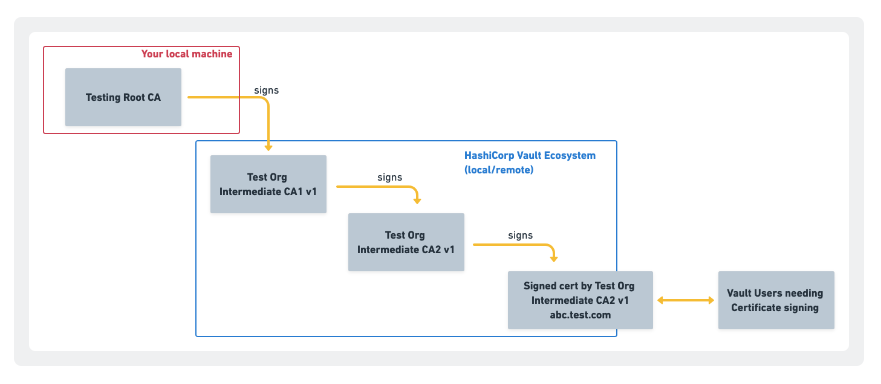

In [ ]:
%%bash
cat > $WORKDIR/main.tf <<EOF
provider "vault" {
}

locals {
 default_3y_in_sec   = 94608000
 default_1y_in_sec   = 31536000
 default_1hr_in_sec = 3600
}
EOF

cat > $WORKDIR/test_org_ica1.tf << EOF
resource "vault_mount" "test_org_v1_ica1_v1" {
 path                      = "test-org/v1/ica1/v1"
 type                      = "pki"
 description               = "PKI engine hosting intermediate CA1 v1 for test org"
 default_lease_ttl_seconds = local.default_1hr_in_sec
 max_lease_ttl_seconds     = local.default_3y_in_sec
}

resource "vault_pki_secret_backend_intermediate_cert_request" "test_org_v1_ica1_v1" {
 depends_on   = [vault_mount.test_org_v1_ica1_v1]
 backend      = vault_mount.test_org_v1_ica1_v1.path
 type         = "internal"
 common_name  = "Intermediate CA1 v1 "
 key_type     = "rsa"
 key_bits     = "2048"
 ou           = "test org"
 organization = "test"
 country      = "US"
 locality     = "Bethesda"
 province     = "MD"
}
EOF

cd $WORKDIR
terraform init
terraform apply -auto-approve

mkdir csr
terraform show -json | jq '.values["root_module"]["resources"][].values.csr' -r | grep -v null > csr/Test_Org_v1_ICA1_v1.csr
 

In [ ]:
%%bash
cat >> $WORKDIR/test_org_ica1.tf << EOF

resource "vault_pki_secret_backend_intermediate_set_signed" "test_org_v1_ica1_v1_signed_cert" {
 depends_on   = [vault_mount.test_org_v1_ica1_v1]
 backend      = vault_mount.test_org_v1_ica1_v1.path

 certificate = file("\${path.module}/cacerts/test_org_v1_ica1_v1.crt")
}

EOF

cd $WORKDIR

terraform apply -auto-approve


In [ ]:
%%bash
curl  -H "X-Vault-Namespace: admin" -s $VAULT_ADDR/v1/test-org/v1/ica1/v1/ca/pem | openssl crl2pkcs7 -nocrl -certfile  /dev/stdin  | openssl pkcs7 -print_certs -noout

In [ ]:
%%bash
curl -H "X-Vault-Namespace: admin" -s $VAULT_ADDR/v1/test-org/v1/ica1/v1/ca_chain | openssl crl2pkcs7 -nocrl -certfile  /dev/stdin  | openssl pkcs7 -print_certs -noout

In [ ]:
%%bash
cat > $WORKDIR/test_org_ica2.tf << EOF
resource "vault_mount" "test_org_v1_ica2_v1" {
 path                      = "test-org/v1/ica2/v1"
 type                      = "pki"
 description               = "PKI engine hosting intermediate CA2 v1 for test org"
 default_lease_ttl_seconds = local.default_1hr_in_sec
 max_lease_ttl_seconds     = local.default_1y_in_sec
}

resource "vault_pki_secret_backend_intermediate_cert_request" "test_org_v1_ica2_v1" {
 depends_on   = [vault_mount.test_org_v1_ica2_v1]
 backend      = vault_mount.test_org_v1_ica2_v1.path
 type         = "internal"
 common_name  = "Intermediate CA2 v1 "
 key_type     = "rsa"
 key_bits     = "2048"
 ou           = "test org"
 organization = "test"
 country      = "US"
 locality     = "Bethesda"
 province     = "MD"
}

resource "vault_pki_secret_backend_root_sign_intermediate" "test_org_v1_sign_ica2_v1_by_ica1_v1" {
 depends_on = [
   vault_mount.test_org_v1_ica1_v1,
   vault_pki_secret_backend_intermediate_cert_request.test_org_v1_ica2_v1,
 ]
 backend              = vault_mount.test_org_v1_ica1_v1.path
 csr                  = vault_pki_secret_backend_intermediate_cert_request.test_org_v1_ica2_v1.csr
 common_name          = "Intermediate CA2 v1.1"
 exclude_cn_from_sans = true
 ou                   = "test org"
 organization         = "test"
 country              = "US"
 locality             = "Bethesda"
 province             = "MD"
 max_path_length      = 1  # Limita la cadena de subordinadas a 1, con lo que no puede haber más intermedias
 ttl                  = local.default_1y_in_sec
}

resource "vault_pki_secret_backend_intermediate_set_signed" "test_org_v1_ica2_v1_signed_cert" {
 depends_on  = [vault_pki_secret_backend_root_sign_intermediate.test_org_v1_sign_ica2_v1_by_ica1_v1]
 backend     = vault_mount.test_org_v1_ica2_v1.path
 certificate = format("%s\n%s", vault_pki_secret_backend_root_sign_intermediate.test_org_v1_sign_ica2_v1_by_ica1_v1.certificate, file("\${path.module}/cacerts/test_org_v1_ica1_v1.crt"))
}
EOF

cd $WORKDIR

terraform apply -auto-approve

In [ ]:
%%bash
curl -H "X-Vault-Namespace: admin" -s $VAULT_ADDR/v1/test-org/v1/ica2/v1/ca/pem | openssl crl2pkcs7 -nocrl -certfile  /dev/stdin  | openssl pkcs7 -print_certs -noout

In [ ]:
%%bash
curl -H "X-Vault-Namespace: admin" -s $VAULT_ADDR/v1/test-org/v1/ica2/v1/ca_chain | openssl crl2pkcs7 -nocrl -certfile  /dev/stdin  | openssl pkcs7 -print_certs -noout

In [ ]:
%%bash
# pathlen:1
curl -H "X-Vault-Namespace: admin" -s $VAULT_ADDR/v1/test-org/v1/ica2/v1/ca/pem | openssl x509 -in /dev/stdin -noout -text | grep "X509v3 extensions"  -A 13

In [ ]:
%%bash
# Creamos un role asociado a la última -CA ica2_v1
cat > $WORKDIR/test_org_ica2_role_test_dot_com.tf << EOF
resource "vault_pki_secret_backend_role" "role" {
 backend            = vault_mount.test_org_v1_ica2_v1.path
 name               = "test-dot-com-subdomain"
 ttl                = local.default_1hr_in_sec
 allow_ip_sans      = true
 key_type           = "rsa"
 key_bits           = 2048
 key_usage          = [ "DigitalSignature"]
 allow_any_name     = false
 allow_localhost    = false
 allowed_domains    = ["test.com"]
 allow_bare_domains = false
 allow_subdomains   = true
 server_flag        = false
 client_flag        = true
 no_store           = true
 country            = ["US"]
 locality           = ["Bethesda"]
 province           = ["MD"]
}

EOF

cd $WORKDIR/

terraform apply -auto-approve

In [ ]:
%%bash
vault write -format=json test-org/v1/ica2/v1/issue/test-dot-com-subdomain \
   common_name=1.test.com | jq .data.certificate -r | openssl x509 -in /dev/stdin -text -noout


In [ ]:
%%bash
# https://registry.terraform.io/providers/hashicorp/vault/latest/docs/resources/pki_secret_backend_cert
cat > $WORKDIR/request_cert.tf << EOF
resource "vault_pki_secret_backend_cert" "app" {
  depends_on = [vault_pki_secret_backend_role.role]

  backend = vault_mount.test_org_v1_ica2_v1.path
  name = vault_pki_secret_backend_role.role.name

  common_name = "app.my.test.com"

  ttl = "1h"
}

output "cert" {
  value = vault_pki_secret_backend_cert.app.certificate
}

EOF

cd $WORKDIR/

terraform apply -auto-approve


In [ ]:
%%bash 
cd $WORKDIR/

terraform output -json | jq .cert.value -r | openssl x509 -in /dev/stdin -text -noout

In [ ]:
%%bash
cat > $WORKDIR/admins.hcl <<EOF
# Manage namespaces

# Enable and manage secrets engines
path "sys/mounts/*" {
   capabilities = ["list"]
}

# List available secrets engines
path "sys/mounts" {
  capabilities = [ "read", "list" ]
}


# Manage secrets at 'pki_int'
path "/pki_int/*" {
   capabilities = ["read", "list"]
}

path "pki_int/issue/example-dot-com" {
   capabilities = ["update"]
   
   control_group = {
    factor "authorizer" {
      identity {
        group_names = [ "acct_manager" ]
        approvals = 1
      }
    }
  }
}
path "test-org/v1/ica2/v1/issue/test-dot-com-subdomain" {
   capabilities = ["update"]
}
EOF

vault policy write admins $WORKDIR/admins.hcl


In [ ]:
%%bash
# Clean up
cd $WORKDIR/

terraform apply -destroy -auto-approve 
cd ..
rm -rf $WORKDIR